# Titanic: Machine Learning from Disaster

## Problem Statement

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

This notebook's workflow is inspired by the insightful kernel shared on Kaggle: https://www.kaggle.com/startupsci/titanic/titanic-data-science-solutions/notebook

In [151]:
##Imports

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

#Feature Selection and Parameter Tuning
import sklearn.cross_validation as cv
import sklearn.feature_selection as fs
import sklearn.grid_search as gs

## Descriptive Statistics

In [152]:
# Transform csv files to corresponding pandas DataFrames
train_df = pd.read_csv('data/train.csv')
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [153]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [154]:
test_df = pd.read_csv('data/test.csv')
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [155]:
train_df.info()
print('-'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

In [156]:
## Incomplete Columns in Training and Test Data
print("Incomplete Training Data Columns: ")
print(np.sum(train_df.loc[:,train_df.isnull().any(axis=0)==True].isnull()))
print("Incomplete Testing Data Columns: ")
print(np.sum(test_df.loc[:,test_df.isnull().any(axis=0)==True].isnull()))

Incomplete Training Data Columns: 
Age         177
Cabin       687
Embarked      2
dtype: int64
Incomplete Testing Data Columns: 
Age       86
Fare       1
Cabin    327
dtype: int64


### Observations:

Although both cabin and Age have significant missing entries in both Training and Test columns, my hypothesis is that they have significant correlation with Survival rate.

In [157]:
#Description of Numerical Variables
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [158]:
#Description of Categorical variables
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Jacobsohn, Mrs. Sidney Samuel (Amy Frances Chr...",male,1601,G6,S
freq,1,577,7,4,644


### Observations

1. Survival rate in training data is 38.38%

2. 65% male population

3. Cabin feature is not unique to passenger with 147 unique entries. This indicates multiple passengers might share the same cabin.

4. Majority of passengers (72.44%) embarked upon Titanic at the Southampton port.

### Hypothesis

Categories of passenger with likely higher survival rate, as mentioned in Problem Statement,

1) Women 

2) Children

3) Pclass = 1 passengers

## Uni-Variate Analysis

In [159]:
# Adding Family as a new Feature column in train_df. Family = Parch + SibSp
train_df['Family'] = train_df['Parch'] + train_df['SibSp']
test_df['Family'] = test_df['Parch'] + train_df['SibSp']

train_df.drop(['Parch','SibSp'],axis=1,inplace=True)
test_df.drop(['Parch','SibSp'],axis=1,inplace=True)

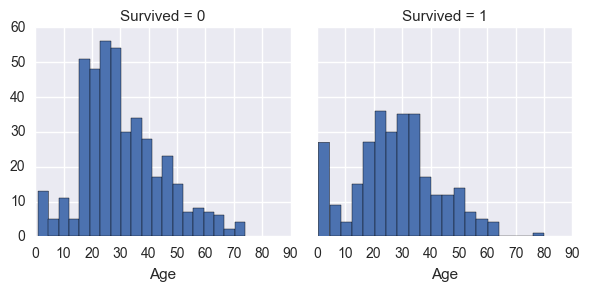

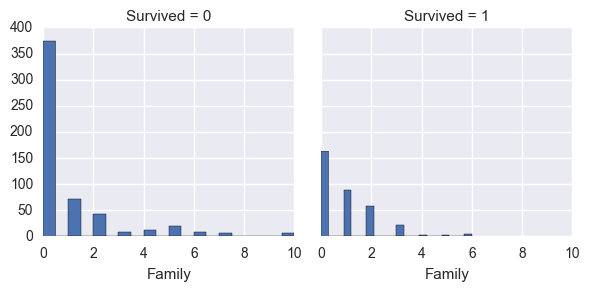

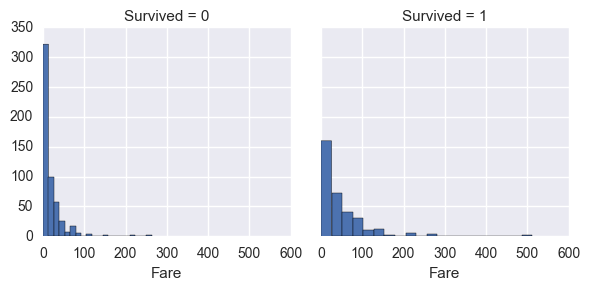

In [160]:
num_features = ['Age','Family','Fare'] #numerical features
#train_df.drop(['Survived','Name','Ticket','Cabin','Sex','Embarked'],axis=1).columns.values

for i in num_features:
    g = sns.FacetGrid(train_df, col='Survived')
    g.map(plt.hist, i, bins=20)

### Observations:

1. Most passengers are in the age group of 15-35 years.

2. Large number of 15-30 year olds didn't survive.

3. Children (age <= 5) have high survival rate

4. For family sizes in the range 1-3, no. of survived > no. of not survived

## Bi-Variate Analysis

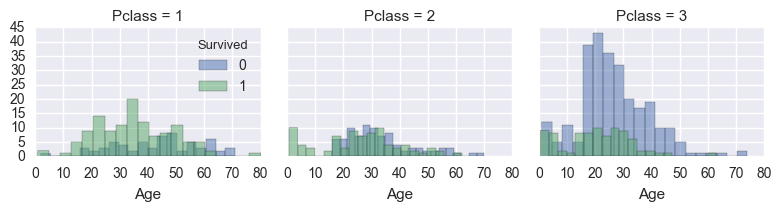

In [161]:
#fig = plt.figure(figsize=(15,15))
#sns.linearmodels.corrplot(train_df)
#plt.title("Correlation Matrix Visualization",fontsize=18)

grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived', size=2.2, aspect=1.2, legend_out=False)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

### Observations:

1) Infants in Pclass = 2 have all survived.

2) Pclass = 3 has most passengers but most did not survive.

3) Pclass = 1 has highest survival rate

4) Both Age and Pclass should be included in Model training.

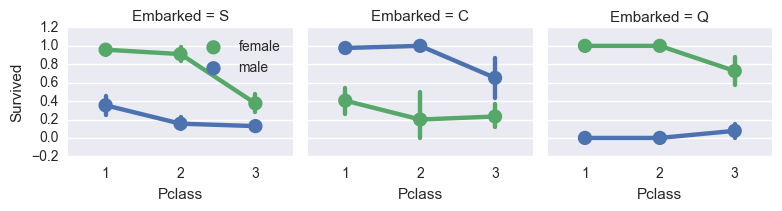

In [162]:
grid = sns.FacetGrid(train_df, col='Embarked', size=2.2, aspect=1.2, legend_out=False)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

In [163]:
train_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

### Observations:

1. Southampton Embarkment with the most passengers had a significantly higher survival rate for women across Pclass 1 and 2.

2. Sex Feature should be included in modeling.

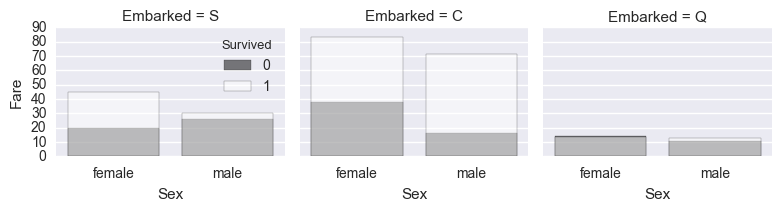

In [164]:
grid = sns.FacetGrid(train_df, col='Embarked', hue='Survived', palette={0: 'k', 1: 'w'}, size=2.2, aspect=1.2, legend_out=False)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

### Observations:

1. Female passengers had had higher fare than men.

2. Higher fare correlates positively with survival probability

## Ticket-Cabin-Fare Analysis

In [165]:
## Data Transformation
#ticket_cabin_df = train_df[['Ticket','Cabin','Fare']]
#ticket_cabin_df.head()
#Dropping Ticket and Cabin as they are shared by multiple passengers
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)

In [166]:
#ticket_cabin_df['Cabin'] = train_df.Cabin.str.extract('(\w+\.)', expand=False)

## Titles

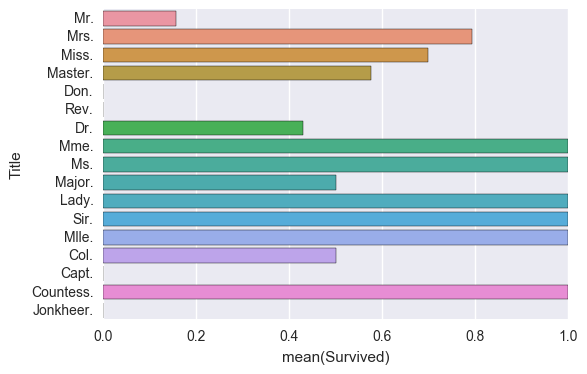

In [167]:
# Adding Title feature
train_df['Title'] = train_df.Name.str.extract('(\w+\.)', expand=False)
sns.barplot(x="Survived", y="Title", data = train_df, ci=False)

### Observations:

1) Titles including Mme., Ms., Mlle. etc. had 100% survival.

2) On the other hand, titles including Mr., Col. Capt. had 0-18% survival

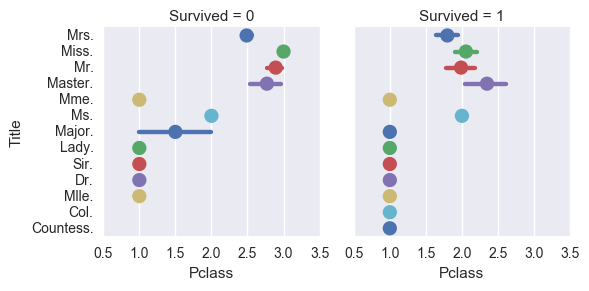

In [168]:
grid = sns.FacetGrid(train_df, col='Survived', legend_out=False)
grid.map(sns.pointplot, 'Pclass', 'Title', palette='deep')
grid.add_legend()

### Observations:

1) Senior titles belonged to Pclass = 1 but still had non-survivors

2) For passengers with Major title, only those in Pclass = 1 survived

3) Title should be included for Modeling

In [169]:
test_df['Title'] = test_df.Name.str.extract('(\w+\.)', expand=False)

train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

## Converting Categorical features to numerical features

In [170]:
#Sex to Gender
train_df['Gender'] = train_df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
test_df['Gender'] = test_df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df = train_df.drop(['Sex'], axis=1)
test_df = test_df.drop(['Sex'], axis=1)

In [171]:
train_df.head()

,Survived,Pclass,Age,Fare,Embarked,Family,Title,Gender
0,0,3,22.0,7.2500,S,1,Mr.,0
1,1,1,38.0,71.2833,C,1,Mrs.,1
2,1,3,26.0,7.9250,S,0,Miss.,1
3,1,1,35.0,53.1000,S,1,Mrs.,1
4,0,3,35.0,8.0500,S,0,Mr.,0


## Completing a numerical continuous feature - Age

In [172]:
# Using correlated features: Pclass, Gender

age_estimate = np.zeros([2,3]) # 2- Gender, 3 - Pclass

for i in range(0, 2):
    for j in range(0, 3):
        guess_df = train_df[(train_df['Gender'] == i) & \
                              (train_df['Pclass'] == j+1)]['Age'].dropna()
        
        age_est = guess_df.median()

        # Convert random age float to nearest .5 age
        age_estimate[i,j] = int(age_est/0.5 + 0.5 ) * 0.5
        
age_estimate

array([[ 40. ,  30. ,  25. ],
       [ 35. ,  28. ,  21.5]])

In [173]:
train_df['AgeFill'] = train_df['Age']

for i in range(0, 2):
    for j in range(0, 3):
        train_df.loc[ (train_df.Age.isnull()) & (train_df.Gender == i) & (train_df.Pclass == j+1),\
                'AgeFill'] = age_estimate[i,j]

#train_df[train_df['Age'].isnull()][['Gender','Pclass','Age','AgeFill']].head(10)

#Also for Testing Data Set
age_estimate = np.zeros([2,3])

for i in range(0, 2):
    for j in range(0, 3):
        guess_df = test_df[(test_df['Gender'] == i) & \
                              (test_df['Pclass'] == j+1)]['Age'].dropna()

        # Correlation of AgeFill is -0.014850
        # age_mean = guess_df.mean()
        # age_std = guess_df.std()
        # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

        # Correlation of AgeFill is -0.011304
        age_est = guess_df.median()

        age_estimate[i,j] = int( age_est/0.5 + 0.5 ) * 0.5

test_df['AgeFill'] = test_df['Age']

for i in range(0, 2):
    for j in range(0, 3):
        test_df.loc[ (test_df.Age.isnull()) & (test_df.Gender == i) & (test_df.Pclass == j+1),\
                'AgeFill'] = age_estimate[i,j]
        
train_df = train_df.drop(['Age'], axis=1)
test_df = test_df.drop(['Age'], axis=1)
train_df.head()        

,Survived,Pclass,Fare,Embarked,Family,Title,Gender,AgeFill
0,0,3,7.2500,S,1,Mr.,0,22.0
1,1,1,71.2833,C,1,Mrs.,1,38.0
2,1,3,7.9250,S,0,Miss.,1,26.0
3,1,1,53.1000,S,1,Mrs.,1,35.0
4,0,3,8.0500,S,0,Mr.,0,35.0


## Completing a categorical feature - Embarked

In [174]:
# With only 2 values missing in Training Data set and 0 in Test Datra Set
# We simply place the most popular Embarkment port for missing data

popular_embarkment = train_df.Embarked.dropna().mode()[0]
popular_embarkment

'S'

In [175]:
train_df['EmbarkedFill'] = train_df['Embarked']
train_df.loc[train_df['Embarked'].isnull(),'EmbarkedFill'] = popular_embarkment

test_df['EmbarkedFill'] = test_df['Embarked']
train_df = train_df.drop(['Embarked'], axis=1)
test_df = test_df.drop(['Embarked'], axis=1)
train_df.head()

,Survived,Pclass,Fare,Family,Title,Gender,AgeFill,EmbarkedFill
0,0,3,7.2500,1,Mr.,0,22.0,S
1,1,1,71.2833,1,Mrs.,1,38.0,C
2,1,3,7.9250,0,Miss.,1,26.0,S
3,1,1,53.1000,1,Mrs.,1,35.0,S
4,0,3,8.0500,0,Mr.,0,35.0,S


## Converting categorical variables to numerical variables

#### Using get_dummies()

In [176]:
# Convert Embarked feature using get_dummies()

#Embarked
Embarked_train_dummy = pd.get_dummies(train_df['EmbarkedFill'])
train_dummy_df = pd.concat([train_df,Embarked_train_dummy],axis=1)
train_dummy_df.drop('EmbarkedFill',axis=1,inplace=True)

Embarked_test_dummy = pd.get_dummies(test_df['EmbarkedFill'])
test_dummy_df = pd.concat([test_df,Embarked_test_dummy],axis=1)
test_dummy_df.drop('EmbarkedFill',axis=1,inplace=True)

#Title
titles_train_dummy = pd.get_dummies(train_dummy_df['Title'])
train_dummy_df = pd.concat([train_dummy_df,titles_train_dummy],axis=1)
#train_df.drop('Title',axis=1,inplace=True)

titles_test_dummy = pd.get_dummies(test_dummy_df['Title'])
test_dummy_df = pd.concat([test_dummy_df,titles_test_dummy],axis=1)

# Disparity in Unique Titles in train_df and test_df
# Some of the titles present in train_df might not be present in test_df
# We need to add zero columns for such titles in the test_df
#Remove Extra Title column from test_df that are absent from train_df

titles_train = list(np.unique(train_dummy_df['Title']))
titles_test = list(np.unique(test_dummy_df['Title']))

titles_extra_in_train_bool = np.array([x not in titles_test for x in titles_train])
titles_extra_in_train = list(np.array(titles_train)[titles_extra_in_train_bool])
#titles_extra_df = pd.DataFrame(np.zeros(()))
print("Extra titles in train_df:")
print(titles_extra_in_train)

titles_extra_in_test_bool = np.array([x not in titles_train for x in titles_test])
titles_extra_in_test = list(np.array(titles_test)[titles_extra_in_test_bool])
print("Extra titles in test_df:")
print(titles_extra_in_test)

# Adding extra Title columns to test_df
Ncols = len(titles_extra_in_train)
titles_extra_to_test_df = pd.DataFrame(np.zeros([test_dummy_df.shape[0],len(titles_extra_in_train)]),columns = titles_extra_in_train)
test_dummy_df = pd.concat([test_dummy_df,titles_extra_to_test_df],axis=1)
test_dummy_df.head()

#Dropping extra columns
test_dummy_df.drop(titles_extra_in_test,axis=1,inplace=True)

Extra titles in train_df:
['Capt.', 'Countess.', 'Don.', 'Jonkheer.', 'Lady.', 'Major.', 'Mlle.', 'Mme.', 'Sir.']
Extra titles in test_df:
['Dona.']


In [177]:
test_dummy_df.drop(['Title','Q','Sir.'],axis =1,inplace=True)
train_dummy_df.drop(['Title','Q','Sir.'],axis=1,inplace=True)

In [178]:
test_dummy_df.head()

,PassengerId,Pclass,Fare,Family,Gender,AgeFill,C,S,Col.,Dr.,...,Ms.,Rev.,Capt.,Countess.,Don.,Jonkheer.,Lady.,Major.,Mlle.,Mme.
0,892,3,7.8292,1.0,0,34.5,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,893,3,7.0000,1.0,1,47.0,0,1,0,0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,894,2,9.6875,0.0,0,62.0,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,895,3,8.6625,1.0,0,27.0,0,1,0,0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,896,3,12.2875,1.0,1,22.0,0,1,0,0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [179]:
train_dummy_df.head()

,Survived,Pclass,Fare,Family,Gender,AgeFill,C,S,Capt.,Col.,...,Lady.,Major.,Master.,Miss.,Mlle.,Mme.,Mr.,Mrs.,Ms.,Rev.
0,0,3,7.2500,1,0,22.0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,1,71.2833,1,1,38.0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,3,7.9250,0,1,26.0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1,1,53.1000,1,1,35.0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,3,8.0500,0,0,35.0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


#### Without dummies

In [180]:
#train_df.columns.values
Ports = list(enumerate(np.unique(train_df['EmbarkedFill'])))
Ports_dict = { name : i for i, name in Ports }              
train_df['Port'] = train_df.EmbarkedFill.map( lambda x: Ports_dict[x]).astype(int)

Ports = list(enumerate(np.unique(test_df['EmbarkedFill'])))
Ports_dict = { name : i for i, name in Ports }
test_df['Port'] = test_df.EmbarkedFill.map( lambda x: Ports_dict[x]).astype(int)

train_df[['EmbarkedFill', 'Port']].head(10)

,EmbarkedFill,Port
0,S,2
1,C,0
2,S,2
3,S,2
4,S,2
5,Q,1
6,S,2
7,S,2
8,S,2
9,C,0


In [181]:
Titles = list(enumerate(np.unique(train_df['Title'])))
Titles_dict = { name : i for i, name in Titles }           
train_df['TitleBand'] = train_df.Title.map( lambda x: Titles_dict[x]).astype(int)

Titles = list(enumerate(np.unique(test_df['Title'])))
Titles_dict = { name : i for i, name in Titles }           
test_df['TitleBand'] = test_df.Title.map( lambda x: Titles_dict[x]).astype(int)

train_df[['Title', 'TitleBand']].head(10)

,Title,TitleBand
0,Mr.,12
1,Mrs.,13
2,Miss.,9
3,Mrs.,13
4,Mr.,12
5,Mr.,12
6,Mr.,12
7,Master.,8
8,Mrs.,13
9,Mrs.,13


In [182]:
train_df = train_df.drop(['EmbarkedFill', 'Title'], axis=1)
test_df = test_df.drop(['EmbarkedFill', 'Title'], axis=1)
train_df.head()

,Survived,Pclass,Fare,Family,Gender,AgeFill,Port,TitleBand
0,0,3,7.2500,1,0,22.0,2,12
1,1,1,71.2833,1,1,38.0,0,13
2,1,3,7.9250,0,1,26.0,2,9
3,1,1,53.1000,1,1,35.0,2,13
4,0,3,8.0500,0,0,35.0,2,12


In [191]:
# Completing one missing value of Fare feature in Test data set
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_dummy_df['Fare'].fillna(test_dummy_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Fare,Family,Gender,AgeFill,Port,TitleBand
0,892,3,7.8292,1.0,0,34.5,1,5
1,893,3,7.0000,1.0,1,47.0,2,6
2,894,2,9.6875,0.0,0,62.0,1,5
3,895,3,8.6625,1.0,0,27.0,2,5
4,896,3,12.2875,1.0,1,22.0,2,6


In [192]:
#Begin Training
X_train = train_df.drop("Survived", axis=1).copy()
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()

X_dummy_train = train_dummy_df.drop("Survived", axis=1).copy()
X_dummy_test  = test_dummy_df.drop("PassengerId", axis=1).copy()

In [193]:
X_dummy_train.shape, Y_train.shape, X_dummy_test.shape

((891, 23), (891,), (418, 23))

## Normalizing Data

In [194]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X_train)
X_train_norm = pd.DataFrame(np_scaled,columns = X_train.columns)
#X_train_norm.head()

np_scaled = min_max_scaler.fit_transform(X_dummy_train)
X_dummy_train_norm = pd.DataFrame(np_scaled,columns = X_dummy_train.columns)
X_dummy_train.head()

,Pclass,Fare,Family,Gender,AgeFill,C,S,Capt.,Col.,Countess.,...,Lady.,Major.,Master.,Miss.,Mlle.,Mme.,Mr.,Mrs.,Ms.,Rev.
0,3,7.2500,1,0,22.0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,71.2833,1,1,38.0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,7.9250,0,1,26.0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1,53.1000,1,1,35.0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,3,8.0500,0,0,35.0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [195]:
np_scaled = min_max_scaler.fit_transform(X_test)
X_test_norm = pd.DataFrame(np_scaled,columns = X_test.columns)
#X_test_norm.head()

np_scaled = min_max_scaler.fit_transform(X_dummy_test)
X_dummy_test_norm = pd.DataFrame(np_scaled,columns = X_dummy_test.columns)
X_dummy_test_norm.head()
#print(np.sum(test_dummy_df.loc[:,test_dummy_df.isnull().any(axis=0)==True].isnull()))

,Pclass,Fare,Family,Gender,AgeFill,C,S,Col.,Dr.,Master.,...,Ms.,Rev.,Capt.,Countess.,Don.,Jonkheer.,Lady.,Major.,Mlle.,Mme.
0,1.0,0.015282,0.1,0.0,0.452723,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.013663,0.1,1.0,0.617566,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.5,0.018909,0.0,0.0,0.815377,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.016908,0.1,0.0,0.353818,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.023984,0.1,1.0,0.287881,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Logistic Regression

In [196]:
logit = LogisticRegression(C=1e4)
logit.fit(X_dummy_train_norm, Y_train)
#Y_pred = logit.predict(X_dummy_test_norm)
logit.score(X_dummy_train_norm, Y_train)

0.83613916947250277

In [197]:
# Feature Importance
coeff_df = pd.DataFrame(X_dummy_train.columns)
coeff_df.columns = ['Features']
coeff_df["Weight"] = pd.Series(logit.coef_[0])

# preview
coeff_df.sort_values(by='Weight', ascending=False)

,Features,Weight
3,Gender,6.506556
1,Fare,1.730256
21,Ms.,1.549320
13,Lady.,1.178156
17,Mlle.,0.861700
9,Countess.,0.811240
18,Mme.,0.525057
5,C,0.135748
6,S,-0.250270
15,Master.,-1.925253


### Observations:

1) With dummies, several features have a significant positive/negative weights for Logistic Regression

In [201]:
## Filtering only features with absolute coeff_ weight greater than 0.5:
features_filter = list(coeff_df.loc[abs(coeff_df.Weight) >= 3,'Features'])
features_filter

['Family',
 'Gender',
 'Capt.',
 'Col.',
 'Don.',
 'Dr.',
 'Jonkheer.',
 'Major.',
 'Miss.',
 'Mr.',
 'Mrs.',
 'Rev.']

In [52]:
#X_train = X_train[features_filter]
#X_test = X_test[features_filter]

#X_train.shape, X_test.shape

## SelectKBest

In [203]:
best2 = fs.SelectKBest(fs.chi2, k='all').fit(X_dummy_train, Y_train)
X_new = best2.transform(X_dummy_train)
#best2.scores_

selectKbest_df = pd.DataFrame(X_dummy_train.columns)
selectKbest_df.columns = ['Features']
selectKbest_df["chi2 Scores"] = pd.Series(best2.scores_)

# preview
selectKbest_df = selectKbest_df.sort_values(by='chi2 Scores', ascending=False)
selectKbest_df

,Features,chi2 Scores
1,Fare,4518.319091
3,Gender,170.348127
19,Mr.,112.805785
20,Mrs.,88.050392
16,Miss.,75.855581
0,Pclass,30.873699
5,C,20.464401
4,AgeFill,19.208594
15,Master.,6.180425
6,S,5.489205


In [204]:
features_filter = list(selectKbest_df.iloc[:10,0])
X_dummy_train_filtered = X_dummy_train[features_filter]
X_dummy_test_filtered = X_dummy_test[features_filter]

## With Dummies

### Random Forest without Filtering

In [205]:
randomForest = RandomForestClassifier()

#grid_para_forest = [{'n_estimators': [10,50]}]
grid_para_forest = [{"n_estimators": [10, 50, 100], "criterion": ["gini", "entropy"], \
                    "min_samples_leaf": np.arange(1, 10), "min_samples_split": np.array([int(x) for x in np.linspace(2, 15,30)])}]
grid_search_forest = gs.GridSearchCV(randomForest, grid_para_forest, scoring='accuracy', cv=5)
grid_search_forest.fit(X_dummy_train, Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'min_samples_split': array([ 2,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  6,  7,  7,  8,  8,  9,
        9, 10, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15]), 'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]), 'n_estimators': [10, 50, 100], 'criterion': ['gini', 'entropy']}],
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [210]:
grid_search_forest.best_params_

{'criterion': 'gini',
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 10}

In [207]:
grid_search_forest.score(X_dummy_train,Y_train)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/grid_search.py:438: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


0.87317620650953987

In [208]:
Y_pred = grid_search_forest.predict(X_dummy_test)

## Without Dummies

### Support Vector Machines

In [51]:
svm_model = SVC()
grid_para_svm = [{'C': [1, 10,100,1000], 'kernel': ['poly'], 'degree': [1,2,3]}, 
                 {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}]

grid_search_svm = gs.GridSearchCV(svm_model, grid_para_svm, scoring = 'accuracy', cv=5)
grid_search_svm.fit(X_train_norm, Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'degree': [1, 2, 3], 'kernel': ['poly'], 'C': [1, 10, 100, 1000]}, {'gamma': [0.001, 0.0001], 'kernel': ['rbf'], 'C': [1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [52]:
grid_search_svm.best_params_

{'C': 1000, 'degree': 2, 'kernel': 'poly'}

In [53]:
grid_search_svm.best_score_

0.8260381593714927

### Random Forests

#### With Normalized Training features

In [54]:
randomForest = RandomForestClassifier()

#grid_para_forest = [{'n_estimators': [10,50]}]
grid_para_forest = [{"n_estimators": [10, 50, 100], "criterion": ["gini", "entropy"], \
                    "min_samples_leaf": np.arange(1, 10), "min_samples_split": np.array([int(x) for x in np.linspace(2, 15,30)])}]
grid_search_forest = gs.GridSearchCV(randomForest, grid_para_forest, scoring='accuracy', cv=5)
grid_search_forest.fit(X_train_norm, Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'min_samples_split': array([ 2,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  6,  7,  7,  8,  8,  9,
        9, 10, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15]), 'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]), 'n_estimators': [10, 50, 100], 'criterion': ['gini', 'entropy']}],
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [55]:
grid_search_forest.grid_scores_

[mean: 0.81257, std: 0.02857, params: {'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 10, 'criterion': 'gini'},
 mean: 0.79798, std: 0.03611, params: {'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 50, 'criterion': 'gini'},
 mean: 0.80359, std: 0.02529, params: {'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 100, 'criterion': 'gini'},
 mean: 0.79125, std: 0.02287, params: {'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 10, 'criterion': 'gini'},
 mean: 0.79686, std: 0.02395, params: {'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 50, 'criterion': 'gini'},
 mean: 0.80920, std: 0.03694, params: {'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 100, 'criterion': 'gini'},
 mean: 0.80359, std: 0.02445, params: {'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 10, 'criterion': 'gini'},
 mean: 0.80135, std: 0.03092, params: {'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 

In [56]:
grid_search_forest.best_score_

0.8428731762065096

In [57]:
grid_search_forest.best_params_

{'criterion': 'gini',
 'min_samples_leaf': 1,
 'min_samples_split': 11,
 'n_estimators': 50}

#### Without Normalization

In [63]:
randomForest = RandomForestClassifier()

#grid_para_forest = [{'n_estimators': [10,50]}]
grid_para_forest = [{"n_estimators": [10, 50, 100], "criterion": ["gini", "entropy"], \
                    "min_samples_leaf": np.arange(1, 10), "min_samples_split": np.array([int(x) for x in np.linspace(2, 15,30)])}]
grid_search_forest = gs.GridSearchCV(randomForest, grid_para_forest, scoring='accuracy', cv=5)
grid_search_forest.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'min_samples_split': array([ 2,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  6,  7,  7,  8,  8,  9,
        9, 10, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15]), 'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]), 'n_estimators': [10, 50, 100], 'criterion': ['gini', 'entropy']}],
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [64]:
grid_search_forest.best_score_

0.8428731762065096

In [65]:
grid_search_forest.best_params_

{'criterion': 'gini',
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'n_estimators': 10}

In [66]:
Y_pred = grid_search_forest.predict(X_test)
grid_search_forest.score(X_train,Y_train)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/grid_search.py:438: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


0.89562289562289565

In [209]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })

submission.to_csv('submission.csv', index=False)